# Planet: Understanding the Amazon deforestation from Space challenge

Special thanks to the kernel contributors of this challenge (especially @anokas and @Kaggoo) who helped me find a starting point for this notebook.

The whole code including the `data_helper.py` and `keras_helper.py` files are available on github [here](https://github.com/EKami/planet-amazon-deforestation) and the notebook can be found on the same github [here](https://github.com/EKami/planet-amazon-deforestation/blob/master/notebooks/amazon_forest_notebook.ipynb)

**If you found this notebook useful some upvotes would be greatly appreciated! :) **

Start by adding the helper files to the python path

In [1]:
import sys

sys.path.append('/home/ubuntu/kaggle/src')
sys.path.append('/home/ubuntu/kaggle/test')
sys.path.append('/home/ubuntu/data/input')

## Import required modules

In [5]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import data_helper
from keras_helper import AmazonKerasClassifier

from itertools import chain

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Print tensorflow version for reuse (the Keras module is used directly from the tensorflow framework)

In [3]:
tf.__version__

'1.1.0'

## Inspect image labels
Visualize what the training set looks like

In [13]:
train_jpeg_dir, test_jpeg_dir, test_jpeg_additional, train_csv_file = data_helper.get_jpeg_data_files_paths()
labels_df = pd.read_csv(train_csv_file)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Each image can be tagged with multiple tags, lets list all uniques tags

In [15]:
# Print all unique tags
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'water', 'primary', 'agriculture', 'road', 'partly_cloudy', 'bare_ground', 'artisinal_mine', 'selective_logging', 'blow_down', 'haze', 'cultivation', 'habitation', 'cloudy', 'conventional_mine', 'clear', 'blooming', 'slash_burn'}


### Repartition of each labels

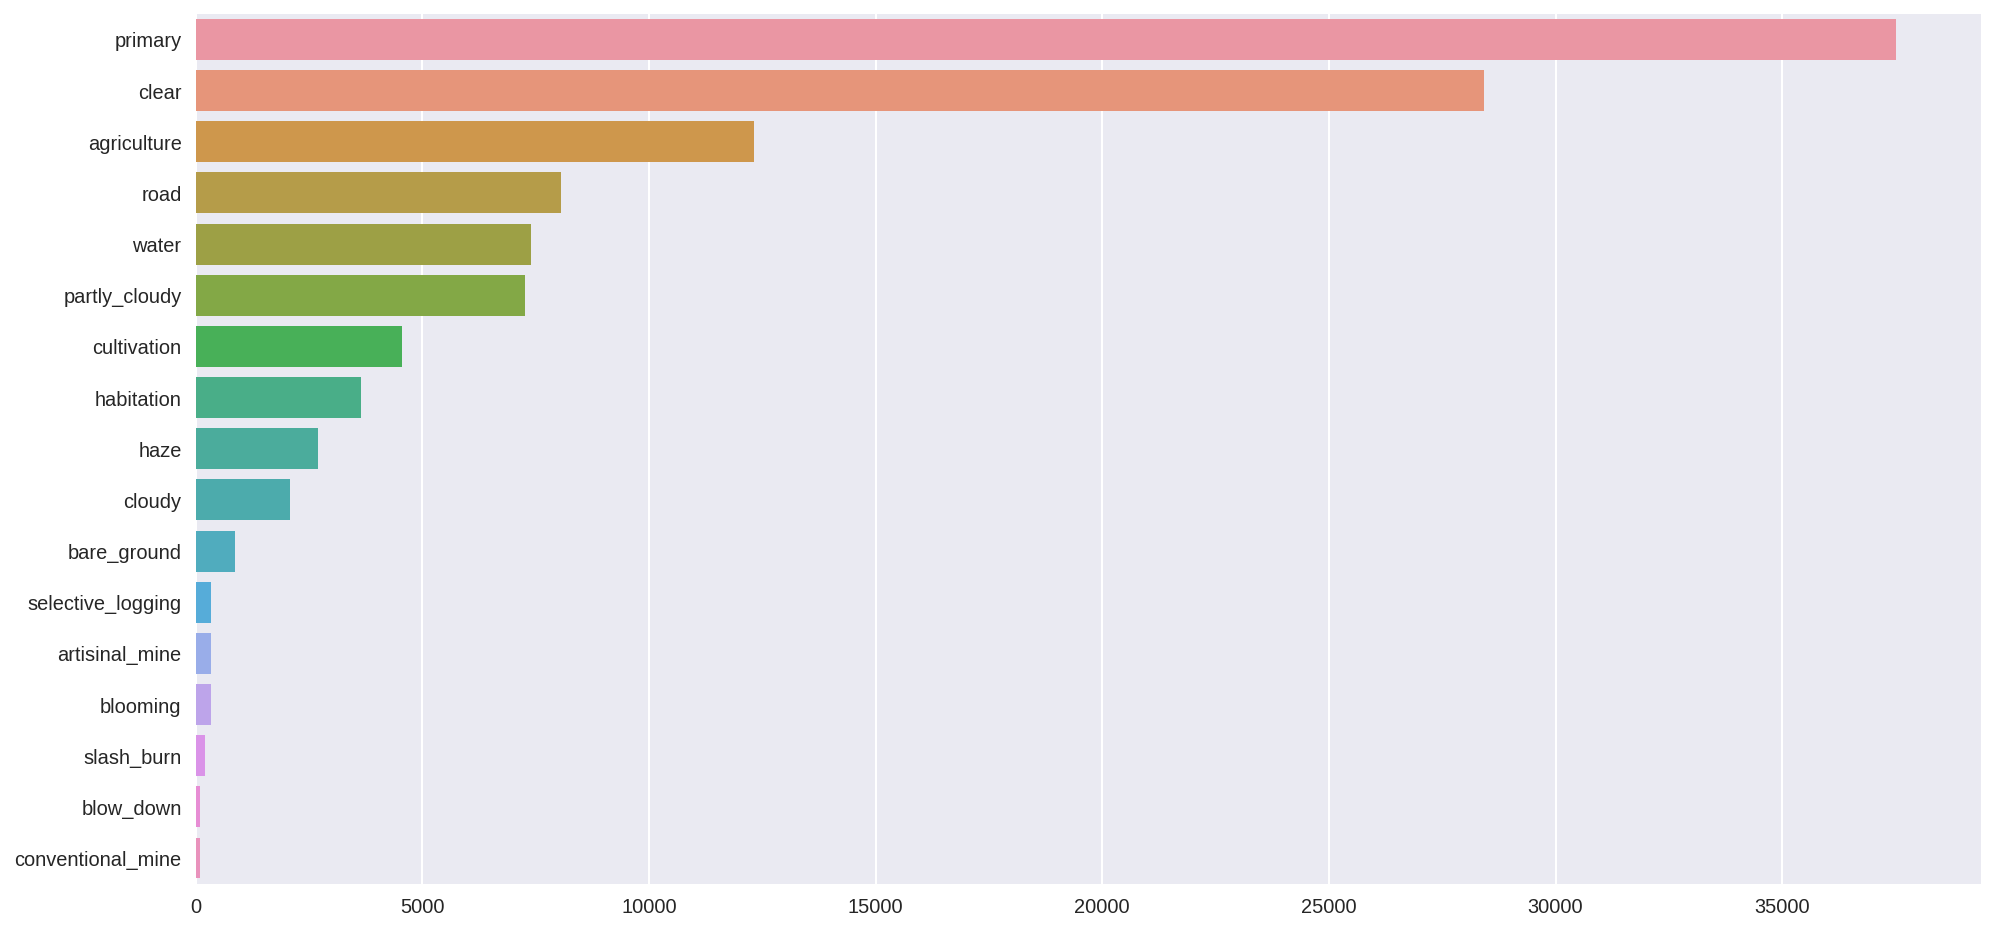

In [17]:
# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

## Images
Visualize some chip images to know what we are dealing with.
Lets vizualise 1 chip for the 17 images to get a sense of their differences.

# Define hyperparameters
Define the hyperparameters of our neural network

# Data preprocessing
Preprocess the data in order to fit it into the Keras model.

Due to the hudge amount of memory the resulting matrices will take, the preprocessing will be splitted into several steps:
    - Preprocess training data (images and labels) and train the neural net with it
    - Delete the training data and call the gc to free up memory
    - Preprocess the first testing set
    - Predict the first testing set labels
    - Delete the first testing set
    - Preprocess the second testing set
    - Predict the second testing set labels and append them to the first testing set
    - Delete the second testing set

## Create the neural network definition

## Monitor the results

Check that we do not overfit by plotting the losses of the train and validation sets

Look at our fbeta_score

Before launching our predictions lets preprocess the test data and delete the old training data matrices

Now lets launch the predictions on the additionnal dataset (updated on 05/05/2017 on Kaggle)

Before mapping our predictions to their appropriate labels we need to figure out what threshold to take for each class.

To do so we will take the median value of each classes.

Now lets map our predictions to their tags and use the thresholds we just retrieved

Finally lets assemble and visualize our prediction for the test dataset

If there is a lot of `primary` and `clear` tags, this final dataset may be legit...

And save it to a submission file

That's it, we're done!